# Topic Modeling

In [249]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from collections import Counter
import text_cleaning_helper_functions as hlf

In [251]:
# open csv and continue cleaning
df = pd.read_csv('final_df.csv')
df.isna().any()
df.dropna(inplace=True)

# ensure single digits and single letters are excluded
df['reviews'] = df['reviews'].replace(r'\d+?', ' ', regex=True)
df['reviews'] = df['reviews'].replace(r'\s[a-z]\s', ' ', regex=True)
stop_words = stopwords.words('english')

In [252]:
# shuffle the reviews and split them into train and test groups - for classification purposes
all_reviews =  df.copy(deep=True)['reviews']
all_reviews = all_reviews.sample(frac=1).reset_index(drop=True)
train_reviews = all_reviews.copy(deep=True)[:401000]
test_reviews =  all_reviews.copy(deep=True)[401000:]

In [253]:
# separate df for join the topic components on
reviews_concat = all_reviews.copy(deep=True)

In [254]:
# sanity check
print(len(train_reviews))
print(len(test_reviews))
print(len(all_reviews))

401000
100828
501828


In [255]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# LDA

In [33]:
def print_topics(model, features, n):
    ''' This model prints and saves the 'N' most important words from every topic '''
    # make sure the features is in a numpy array to use .argsort
    if type(features) == list:
        features = np.array(features)
    
    # save the n most important words for each topic
    components = model.components_ 
    top_n = [features[component.argsort()][-n-1:] for component in components]
    
    # print the top words for every each topic
    for i in range(len(top_n)):
        print(f"Topic {i+1} most important words: {top_n[i]}")
    return top_n

In [41]:
# vectorize the data and get check what the top words
tf_idf_vectorize = TfidfVectorizer(max_df=0.5, max_features=10000,
                                  min_df=10, use_idf=True)

tf_idf = tf_idf_vectorize.fit_transform(all_reviews)

# extract feature name and run LDA model (there are 14~ type of products in amazon's electronic department)
features = tf_idf_vectorize.get_feature_names()
LDA = LatentDirichletAllocation(n_components=14, random_state=1234,
                                n_jobs=-1, verbose=1).fit(tf_idf)

LDA_topics = hlf.print_topics(LDA, features , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['reception' 'radio' 'screw' 'work' 'cable' 'wall' 'channel' 'signal'
 'mount' 'tv' 'antenna']
Topic 2 most important words: ['cord' 'charging' 'phone' 'plug' 'work' 'usb' 'cable' 'power' 'charger'
 'charge' 'battery']
Topic 3 most important words: ['hand' 'feel' 'like' 'battery' 'use' 'work' 'logitech' 'button' 'key'
 'keyboard' 'mouse']
Topic 4 most important words: ['memory' 'speed' 'data' 'file' 'hard' 'computer' 'work' 'gb' 'usb' 'card'
 'drive']
Topic 5 most important words: ['tablet' 'stand' 'hold' 'strap' 'like' 'kindle' 'bag' 'ipad' 'fit'
 'cover' 'case']
Topic 6 most important words: ['good' 'cover' 'work' 'dust' 'like' 'case' 'plastic' 'product' 'bubble'
 'pro

In [205]:
# add the topics to next to the reviews
LDA_topics = pd.DataFrame(LDA.transform(tf_idf))

# get the highest value from every row
max_val = LDA_topics.max(axis=1)

topic_names = [f"topic_{c}" for c in LDA_topics.columns]
LDA_topics.columns = topic_names

reviews_with_topics = pd.concat([reviews_concat, doc_topics, max_val], axis=1)
reviews_with_topics.head()

,reviews,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,0
0,audiophile wanted decent set earbuds replac...,0.011433,0.011433,0.011434,0.058429,0.011434,0.011433,0.815802,0.011433,0.011433,0.011433,0.011434,0.011434,0.011433,0.815802
1,iphone g iphone ipod touch nd gen th gen ...,0.017072,0.017072,0.017072,0.017072,0.091267,0.017072,0.017072,0.017072,0.720944,0.017071,0.017072,0.017072,0.017072,0.720944
2,day use salt water got inside antenna mount ...,0.016927,0.016927,0.016930,0.016927,0.016927,0.103957,0.016927,0.016927,0.344292,0.016928,0.016927,0.382476,0.016927,0.382476
3,bought security camera like others v input vid...,0.012028,0.023043,0.337049,0.012028,0.345856,0.012028,0.012029,0.012028,0.012028,0.012028,0.012029,0.012028,0.185797,0.345856
4,work guess window detected installed issue e...,0.012533,0.012533,0.012533,0.012533,0.625482,0.012533,0.012533,0.012533,0.012533,0.012533,0.236656,0.012533,0.012533,0.625482


# LDA Bigarm

In [43]:
# tfidf bigrams
tf_idf_n2_vec = TfidfVectorizer(max_df=0.5, max_features=10000,
                                min_df=10, use_idf=True, 
                                ngram_range=(1, 2))

# extract features name and run the model
tf_idf_n2 = tf_idf_n2_vec.fit_transform(all_reviews)
features_n2 = tf_idf_n2_vec.get_feature_names()

LDA_n2 = LatentDirichletAllocation(n_components=14, random_state=1234,
                                   n_jobs=-1, verbose=1).fit(tf_idf_n2)

LDA_n2_topics = hlf.print_topics(LDA_n2, features_n2 , 14)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topic 1 most important words: ['item' 'use' 'charge' 'bought' 'buy' 'easy' 'quality' 'work great'
 'recommend' 'product' 'good' 'great' 'work' 'price' 'battery']
Topic 2 most important words: ['problem' 'port' 'wireless' 'file' 'support' 'network' 'driver' 'device'
 'software' 'computer' 'usb' 'work' 'drive' 'router' 'window']
Topic 3 most important words: ['good' 'work' 'product' 'touch' 'stylus' 'use' 'like' 'ipad' 'bubble'
 'screen protector' 'tablet' 'key' 'protector' 'keyboard' 'screen']
Topic 4 most important words: ['netflix' 'device' 'ray' 'play' 'monitor' 'movie' 'picture' 'work'
 'cable' 'video' 'hdmi' 'dvd' 'player' 'remote' 'tv']
Topic 5 most important words: ['like' 'great' 'noise' 'pair

# Gensim LDA

In [256]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize 

In [257]:
# tokenize reviews
tokened_reviews = [word_tokenize(i) for i in all_reviews]

# create dictionary and filter out words that appear in less than 10 documents or in more than 50% of documents 
dictionary = gensim.corpora.Dictionary(tokened_reviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=8000)

# create corpus
corpus = [dictionary.doc2bow(doc) for doc in tokened_reviews]

gensim_LDA = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, 
                                       passes=3, workers=4, per_word_topics=True,
                                       random_state=123)
topics = gensim_LDA.show_topics(formatted=False)
# print the 7 most important words in every topic
for ind, words in gensim_LDA.print_topics(-1, 7):
    print(f'Topic {ind+1}: {words}')

Topic 1: 0.047*"camera" + 0.022*"lens" + 0.009*"canon" + 0.009*"picture" + 0.009*"light" + 0.009*"good" + 0.008*"image"
Topic 2: 0.020*"keyboard" + 0.015*"unit" + 0.014*"key" + 0.009*"time" + 0.008*"button" + 0.008*"one" + 0.008*"gps"
Topic 3: 0.035*"sound" + 0.019*"speaker" + 0.016*"headphone" + 0.013*"good" + 0.013*"quality" + 0.012*"ear" + 0.008*"like"
Topic 4: 0.036*"cable" + 0.024*"usb" + 0.020*"work" + 0.018*"power" + 0.014*"adapter" + 0.013*"port" + 0.013*"one"
Topic 5: 0.018*"drive" + 0.017*"one" + 0.013*"product" + 0.011*"time" + 0.011*"would" + 0.010*"work" + 0.010*"amazon"
Topic 6: 0.053*"battery" + 0.026*"mouse" + 0.016*"charge" + 0.014*"use" + 0.013*"work" + 0.012*"one" + 0.011*"button"
Topic 7: 0.032*"card" + 0.022*"video" + 0.012*"radio" + 0.011*"camera" + 0.011*"use" + 0.011*"player" + 0.010*"file"
Topic 8: 0.029*"case" + 0.011*"like" + 0.011*"screen" + 0.011*"ipad" + 0.011*"fit" + 0.010*"one" + 0.010*"cover"
Topic 9: 0.013*"router" + 0.011*"device" + 0.010*"window" + 0

In [413]:
gensim_LDA.show_topics(formatted=True)

[(0,
  '0.047*"camera" + 0.022*"lens" + 0.009*"canon" + 0.009*"picture" + 0.009*"light" + 0.009*"good" + 0.008*"image" + 0.008*"quality" + 0.008*"use" + 0.007*"get"'),
 (1,
  '0.020*"keyboard" + 0.015*"unit" + 0.014*"key" + 0.009*"time" + 0.008*"button" + 0.008*"one" + 0.008*"gps" + 0.008*"use" + 0.008*"get" + 0.007*"device"'),
 (2,
  '0.035*"sound" + 0.019*"speaker" + 0.016*"headphone" + 0.013*"good" + 0.013*"quality" + 0.012*"ear" + 0.008*"like" + 0.008*"music" + 0.008*"volume" + 0.008*"bass"'),
 (3,
  '0.036*"cable" + 0.024*"usb" + 0.020*"work" + 0.018*"power" + 0.014*"adapter" + 0.013*"port" + 0.013*"one" + 0.012*"plug" + 0.009*"device" + 0.009*"use"'),
 (4,
  '0.018*"drive" + 0.017*"one" + 0.013*"product" + 0.011*"time" + 0.011*"would" + 0.010*"work" + 0.010*"amazon" + 0.009*"back" + 0.009*"get" + 0.009*"problem"'),
 (5,
  '0.053*"battery" + 0.026*"mouse" + 0.016*"charge" + 0.014*"use" + 0.013*"work" + 0.012*"one" + 0.011*"button" + 0.010*"charger" + 0.009*"like" + 0.008*"time"'),

In [376]:
for i, row in enumerate(gensim_LDA[corpus]):
    print(row[0])
    break

[(0, 0.0100077065), (1, 0.010008799), (2, 0.44036886), (3, 0.010007575), (4, 0.4795705), (5, 0.010007856), (6, 0.01000677), (7, 0.010007284), (8, 0.010007167), (9, 0.010007516)]


In [416]:
for i, row in enumerate(gensim_LDA[corpus]):
    for topic in row:
        topic = print(sorted(topic[0]))
        break

[0, 0.010007707]
[0.5913281, 3]
[0.9868738, 2]
[0.20801786, 2]
[0, 0.9689098]
[0.09636207, 1]
[0.51034707, 4]
[0.12073214, 4]
[0.026822986, 3]
[0.97426814, 3]
[0, 0.16165066]
[0.49386832, 1]
[0.93568265, 5]
[0, 0.6036135]
[0, 0.062114533]
[0.32692173, 4]
[0.7762656, 4]
[0.8942398, 4]
[0, 0.01428947]
[0.50607634, 2]
[0.025326898, 2]
[0, 0.4255661]
[0, 0.6610653]
[0.14739196, 1]
[0.09004816, 3]
[0.98084474, 6]
[0, 0.49197245]
[0, 0.32797855]
[0, 0.08723344]
[0.09169903, 3]
[0.93568844, 9]
[0.7553344, 4]
[0, 0.0805371]
[0, 0.12929638]
[0, 0.9512829]
[0, 0.3204704]
[0, 0.010007628]
[0.5002148, 3]
[0.23522927, 1]
[0.48502132, 3]
[0, 0.0111131]
[0.9859208, 9]
[0.017961575, 3]
[0, 0.06587738]
[0.8904772, 2]
[0.09495166, 6]
[0, 0.3898269]
[0.02981559, 1]
[0.4706093, 2]
[0, 0.41846004]
[0.9859275, 2]
[0.12763481, 2]
[0.48789704, 1]
[0.07391109, 3]
[0.72888625, 4]
[0.2611017, 1]
[0.4523643, 4]
[0.55588275, 4]
[0, 0.28755355]
[0.1271421, 3]
[0, 0.6944703]
[0.05579495, 1]
[0.94372517, 4]
[0.023203

[0.27800325, 3]
[0, 0.01922668]
[0, 0.1747992]
[0, 0.2677383]
[0, 0.7459266]
[0.7035789, 2]
[0.33339772, 4]
[0.24347122, 1]
[0.40700445, 1]
[0, 0.57723665]
[0.17533576, 1]
[0.3819584, 4]
[0.20354888, 2]
[0.29745182, 2]
[0.15148799, 2]
[0.3358258, 2]
[0, 0.4136156]
[0.23670585, 2]
[0.4376193, 5]
[0.7882699, 2]
[0.27013627, 2]
[0.3842214, 2]
[0.09649199, 3]
[0.04001291, 4]
[0.9530161, 2]
[0.07516472, 4]
[0.96085966, 3]
[0.876049, 2]
[0.21376285, 1]
[0.24662852, 4]
[0.35686672, 4]
[0.87975454, 4]
[0, 0.1472134]
[0, 0.011118705]
[0.060011767, 4]
[0.21021612, 4]
[0.9709478, 8]
[0, 0.5880579]
[0, 0.12671712]
[0.70544034, 2]
[0.8303277, 4]
[0.18163146, 3]
[0.067012094, 3]
[0.05865266, 1]
[0.3409642, 1]
[0, 0.01836693]
[0, 0.14641048]
[0, 0.38830826]
[0.8080485, 5]
[0.31037948, 3]
[0, 0.99165887]
[0.12063983, 3]
[0.5200726, 5]
[0.91814727, 3]
[0, 0.12458713]
[0.46372855, 6]
[0.64810485, 2]
[0.04347678, 3]
[0, 0.55608386]
[0.11303057, 3]
[0.31690553, 3]
[0, 0.11970571]
[0.9181338, 4]
[0.1496854

KeyboardInterrupt: 

In [358]:
for i, row in enumerate(gensim_LDA[corpus][:2]):
    for topic in row:
        topic = print(sorted(topic[0]))
        break

        

[0, 0.010007707]
[0.5912663, 3]


In [414]:
def format_topics_sentences(model, corpus, text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]))
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), topic_keywords]), 
                                                                        ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [415]:
df_topic_sents_keywords = format_topics_sentences(gensim_LDA, corpus, tokened_reviews)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [329]:
def create_word_clouds(model, n=2, j=5, save=0, start=0, stop=None):
    """
    create_word_clouds(model, n, j, save, start, stop):
    Params:
        model: gensim LDA model object
        n: number of subplots in a column  (default=2)
        j: number of subplots in a row (default=5)
        save: save the figure (optional, default=0)
        start: from what number topic you wish to create the subplot (optional, default=0)
        stop: stop the subplot at a certain topic (optional, default=None)
        
    Returns:
        Word cloud image for every topic LDA created
    """
    # create color list
    colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]
    
    # instantiate cloud
    cloud = WordCloud(background_color='white',
                      width=1028,
                      height=726,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[start],
                      prefer_horizontal=1.0)
    
    # extract topics
    topics = model.show_topics(formatted=False)
    
    # create subplots 
    fig, axes = plt.subplots(n, j, figsize=(10,10), sharex=True, sharey=True)
    
    for ax in axes.flatten():
        fig.add_subplot(ax)
        topic_words = dict(topics[start][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(start+1), fontdict=dict(size=16))
        # hide axis
        plt.gca().axis('off')
        start += 1
        if start == stop:
            break
        
    plt.subplots_adjust(wspace=0, hspace=0)
    # hide axis
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    if save:
        plt.savefig(f'topics_cloud{start}.png')
    plt.show()

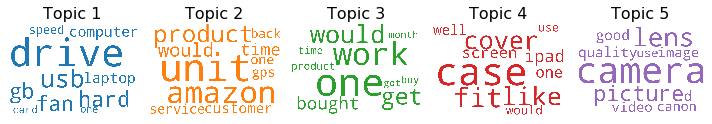

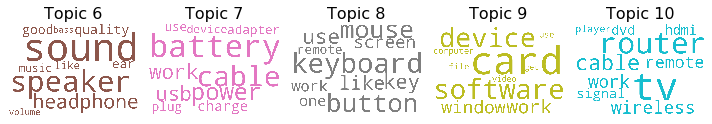

In [242]:
# plot and save the different topics. each word is sized by how many time they repeat
for start in [0, 5]:
    hlf.create_word_clouds(gensim_LDA, n=1, j=5, save=0, start=start)